In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as Tdata
import torch.nn.functional as F
import torch.distributions as TD

from tqdm.notebook import tqdm

if torch.cuda.is_available():
    DEVICE = 'cuda'
    # GPU_DEVICE = 2
    # torch.cuda.set_device(GPU_DEVICE)
else:
    DEVICE='cpu'

print(DEVICE)

import warnings
warnings.filterwarnings('ignore')

# typing
from typing import List, Tuple

cuda


In [2]:
from dgm_utils import plot_training_curves
from dgm_utils import show_samples, visualize_images, load_dataset

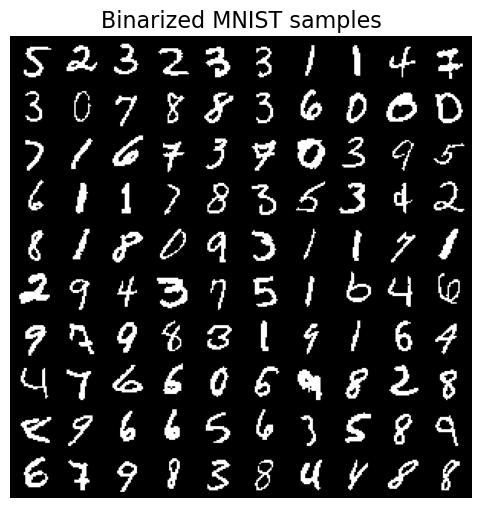

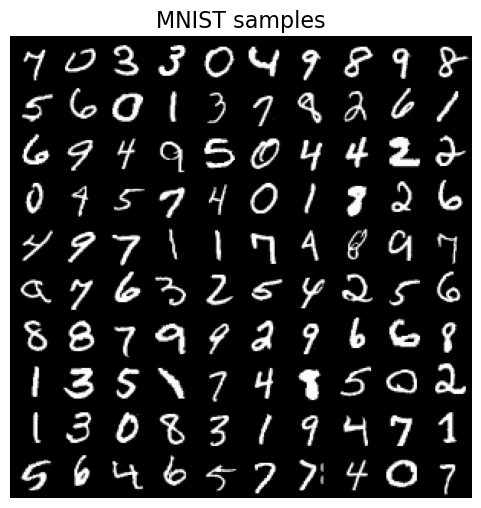

In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
train_data_bin, test_data_bin = load_dataset("mnist", flatten=False, binarize=True)
visualize_images(train_data_bin, "Binarized MNIST samples")
train_data, test_data = load_dataset("mnist", flatten=False, binarize=False)
visualize_images(train_data, "MNIST samples")

In [4]:
class MaskedConv2d(nn.Conv2d):
    def __init__(
        self, 
        mask_type: str, 
        in_channels: int, 
        out_channels: int, 
        kernel_size: int = 5
    ) -> None:
        assert mask_type in ["A", "B"]
        super().__init__(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
        )
        self.register_buffer("mask", torch.zeros_like(self.weight))
        self.create_mask(mask_type)

    def forward(
        self, 
        input: torch.Tensor
    ) -> torch.Tensor:
        # ====
        # your code
        return F.conv2d(input, self.weight * self.mask, self.bias, padding=self.padding)
        # ====

    def create_mask(
        self, 
        mask_type: str
    ) -> None:
        # ====
        # your code
        # do not forget about mask_type
        k = self.kernel_size[0]
        self.mask[:, :, : k // 2] = 1
        self.mask[:, :, k // 2, : k // 2] = 1
        if mask_type == "B":
            self.mask[:, :, k // 2, k // 2] = 1
        # ====


def test_masked_conv2d():
    layer = MaskedConv2d("A", 2, 2)
    assert np.allclose(layer.mask[:, :, 2, 2].numpy(), np.zeros((2, 2)))

    layer = MaskedConv2d("B", 2, 2)
    assert np.allclose(layer.mask[:, :, 2, 2].numpy(), np.ones((2, 2)))


test_masked_conv2d()

In [5]:
class LayerNorm(nn.LayerNorm):
    def __init__(self, n_filters: int) -> None:
        super().__init__(n_filters)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.permute(0, 2, 3, 1).contiguous()
        x = super().forward(x)
        return x.permute(0, 3, 1, 2).contiguous()

In [6]:
class PixelCNNGeneric(nn.Module):

    def __init__(
        self,
        spat_shape: Tuple[int],
        hid_chans: List[int] = [64, 64, 64, 64, 64],
        out_chan: int = 2,
        kernel_size: int = 7,
        use_layer_norm: bool = True,
    ) -> None:

        super().__init__()
        self.spat_shape = spat_shape
        self.out_chan = out_chan

        # ====
        # your code
        # apply the sequence of MaskedConv2d -> LayerNorm (it is optional) -> ReLU
        # the last layer should be MaskedConv2d (not ReLU) Question: Why?
        # Note 1: the first conv layer should be of type 'A'
        # Note 2: final output_dim in MaskedConv2d must be out_chan
        model = [MaskedConv2d("A", 1, hid_chans[0], kernel_size=kernel_size)]

        for in_hid_chan, out_hid_chan in zip(hid_chans[:-1], hid_chans[1:]):
            if use_layer_norm:
                model.append(LayerNorm(in_hid_chan))
            model.append(nn.ReLU())
            model.append(
                MaskedConv2d("B", in_hid_chan, out_hid_chan, kernel_size=kernel_size)
            )

        model.extend(
            [
                nn.ReLU(),
                MaskedConv2d("B", in_channels=hid_chans[-1], out_channels=out_chan, kernel_size=1),
            ]
        )

        self.net = nn.Sequential(*model)
        # ====

    def forward(
        self, x: torch.Tensor
    ) -> torch.Tensor:
        batch_size = x.shape[0]
        out = (x.float() - 0.5) / 0.5 # Why?
        out = self.net(out)
        # =====
        # your code
        return out.view(batch_size, self.out_chan, 1, *self.spat_shape)
        # =====

In [7]:
import itertools

class CrossEntropyPixelCNNGeneric(PixelCNNGeneric):

    def __init__(
        self,
        spat_shape: Tuple[int],
        hid_chans: List[int] = [64, 64, 64, 64, 64],
        out_chan: int = 2,
        kernel_size: int = 7,
        use_layer_norm: bool = True,
    ) -> None:

        assert out_chan >= 2

        super().__init__(
            spat_shape, 
            hid_chans=hid_chans, 
            out_chan=out_chan, 
            kernel_size=kernel_size, 
            use_layer_norm=use_layer_norm)

        #Note! Will average the output (i.e., returns scaled log likelihood)
        # =======
        # your code
        self.loss_fn = nn.CrossEntropyLoss()
        # ======

    def sample(
        self, n: int
    ) -> np.ndarray:
        # =====
        # your code
        # Note 1: Use torch.multinomial
        # Note 2: Output values should be in [0,1]
        samples = torch.zeros(n, 1, *self.spat_shape).to(DEVICE)
        ordering = itertools.product(range(self.spat_shape[0]), range(self.spat_shape[1]))
        with torch.no_grad():
            for (r, c) in ordering:
                logits = self(samples)[..., r, c] # (bs, out_chan=K, 1)
                probs = F.softmax(logits.squeeze(-1), dim=1) # (bs, out_chan)
                samples[..., r, c] = torch.multinomial(probs, num_samples=1) / float(self.out_chan - 1) # grayscale [0,1]
        # =====
        return samples.cpu().numpy()

In [8]:
class BinarizedPixelCNN(CrossEntropyPixelCNNGeneric):
    def __init__(
        self,
        spat_shape: Tuple[int],
        hid_chans: List[int] = [64, 64, 64, 64, 64],
        kernel_size: int = 7,
        use_layer_norm: bool = True,
    ) -> None:

        super().__init__(
            spat_shape, 
            hid_chans=hid_chans, 
            out_chan=2, 
            kernel_size=kernel_size, 
            use_layer_norm=use_layer_norm)

    def loss(self, x: torch.Tensor) -> dict:
        # ====
        # your code
        total_loss = self.loss_fn(self(x), x.long())
        # ====
        return {"total_loss": total_loss}

In [9]:
class GrayScalePixelCNN(CrossEntropyPixelCNNGeneric):
    def __init__(
        self,
        spat_shape: Tuple[int],
        hid_chans: List[int] = [64, 128, 256, 512, 256],
        kernel_size: int = 7,
        use_layer_norm: bool = True,
    ) -> None:

        super().__init__(
            spat_shape, 
            hid_chans=hid_chans, 
            out_chan=256, 
            kernel_size=kernel_size, 
            use_layer_norm=use_layer_norm)

    def loss(self, x: torch.Tensor) -> dict:
        # ====
        # your code
        # Note: x in [0, 1]
        total_loss = self.loss_fn(self(x), (x * 255.).long())
        # ====
        return {"total_loss": total_loss}

In [10]:
from dgm_utils import train_model
from torch.optim import Adam

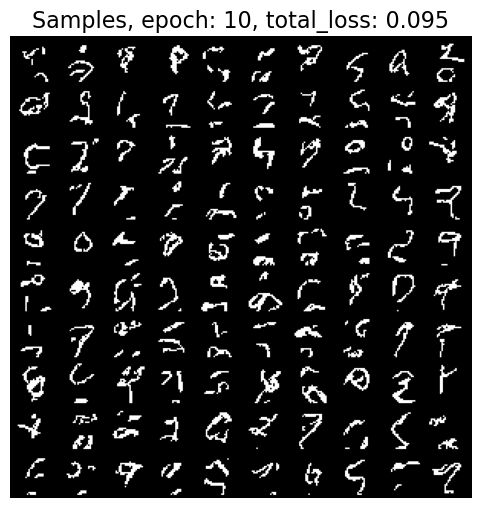

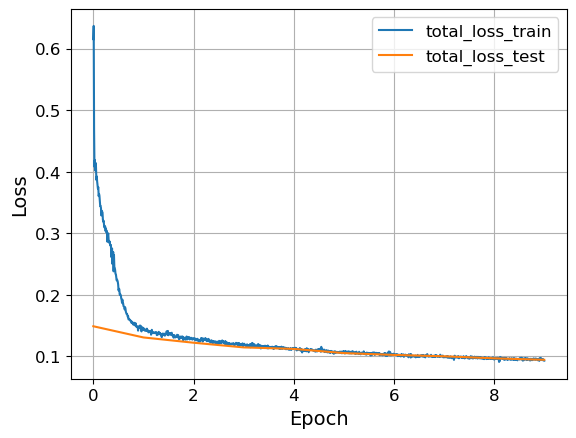

End of the training


In [ ]:
# ====
# set your params
EPOCHS = 50  # > 5
BATCH_SIZE = 512  # any adequate value
LR = 1e-3  # < 1e-2
N_LAYERS = 5  # < 10
N_FILTERS = 128  # < 128
USE_LAYER_NORM = True
# ====

model = BinarizedPixelCNN(
    spat_shape=(28, 28),
    hid_chans = [N_FILTERS,] * N_LAYERS,
    kernel_size=5,
    use_layer_norm=USE_LAYER_NORM,
).to(DEVICE)

train_loader = Tdata.DataLoader(train_data_bin, batch_size=BATCH_SIZE, shuffle=True)
test_loader = Tdata.DataLoader(test_data_bin, batch_size=BATCH_SIZE)

optimizer = Adam(model.parameters(), lr=LR)

train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=EPOCHS,
    optimizer=optimizer,
    scheduler=None,  # No scheduler for a constant learning rate
    device=DEVICE,
    loss_key="total_loss",  # Use the default loss key or specify as needed
    n_samples=100,  # Set number of samples for visualization
    visualize_samples=True  # Set to False if you don't want visualization
)